In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [203]:
raw_data = pd.read_csv('../datasets/doordash_historical_data.csv')
data = raw_data.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

<AxesSubplot:>

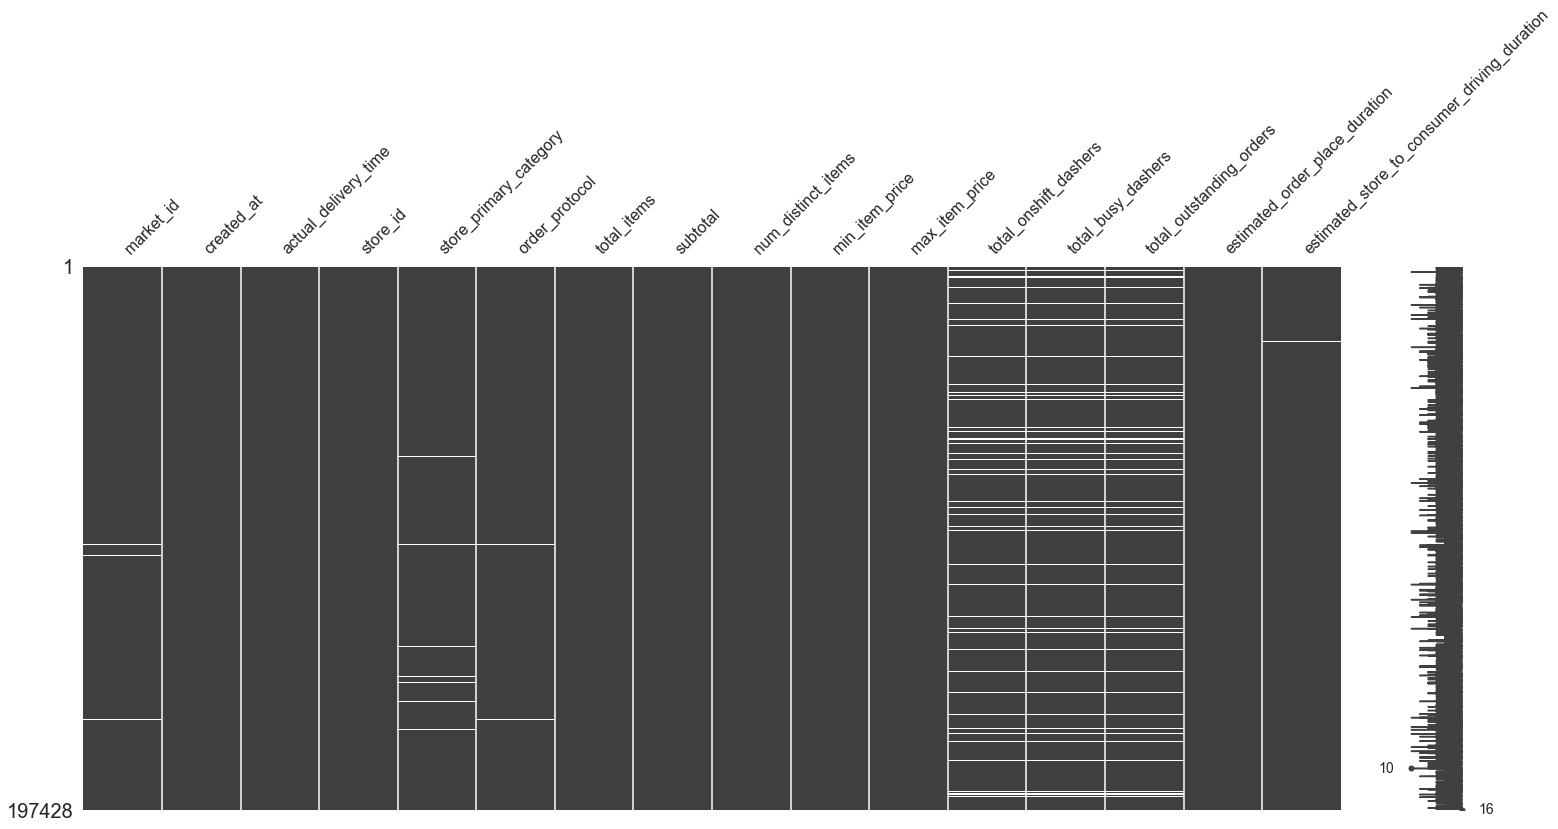

In [204]:
import missingno as msno

msno.matrix(data)

Since our dataset is fairly large, we can consider deleting rows with missing values if it is unlikely to cause bias in our sample.

We observe that there are quite a number of missing rows in columns ```total_onshift_dashers```, ```total_busy_dashers```, ```total_outstanding_orders```. For these columns we can impute missing values with mean values.

In [205]:
data = data.dropna(subset=['market_id','store_primary_category', 'order_protocol'])

<AxesSubplot:>

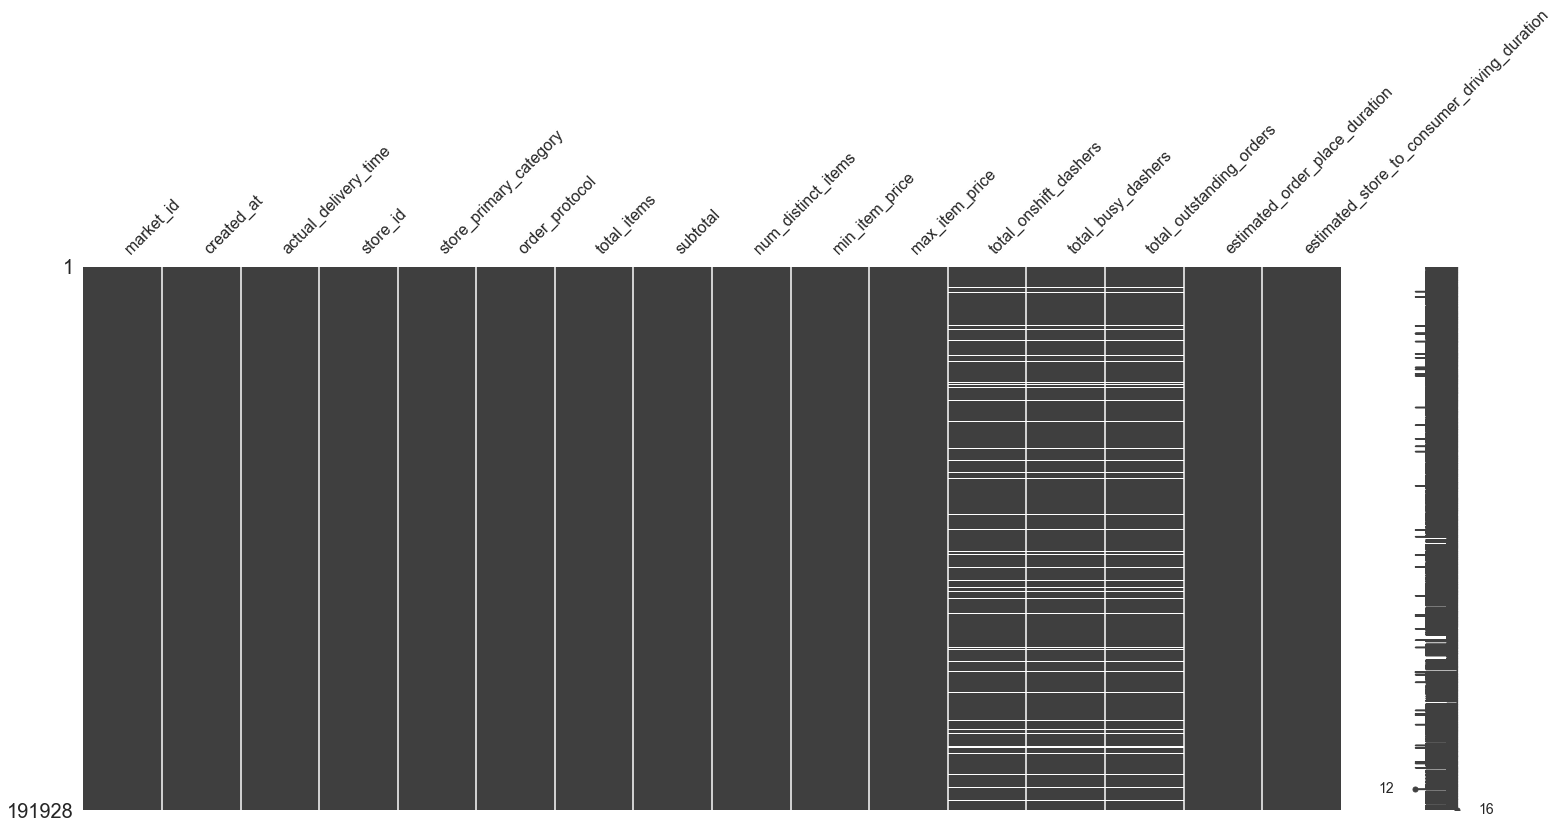

In [206]:
msno.matrix(data)

In [207]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(data[['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders']])
data[['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders']] = imputer.transform(data[['total_onshift_dashers','total_busy_dashers', 'total_outstanding_orders']])

<AxesSubplot:>

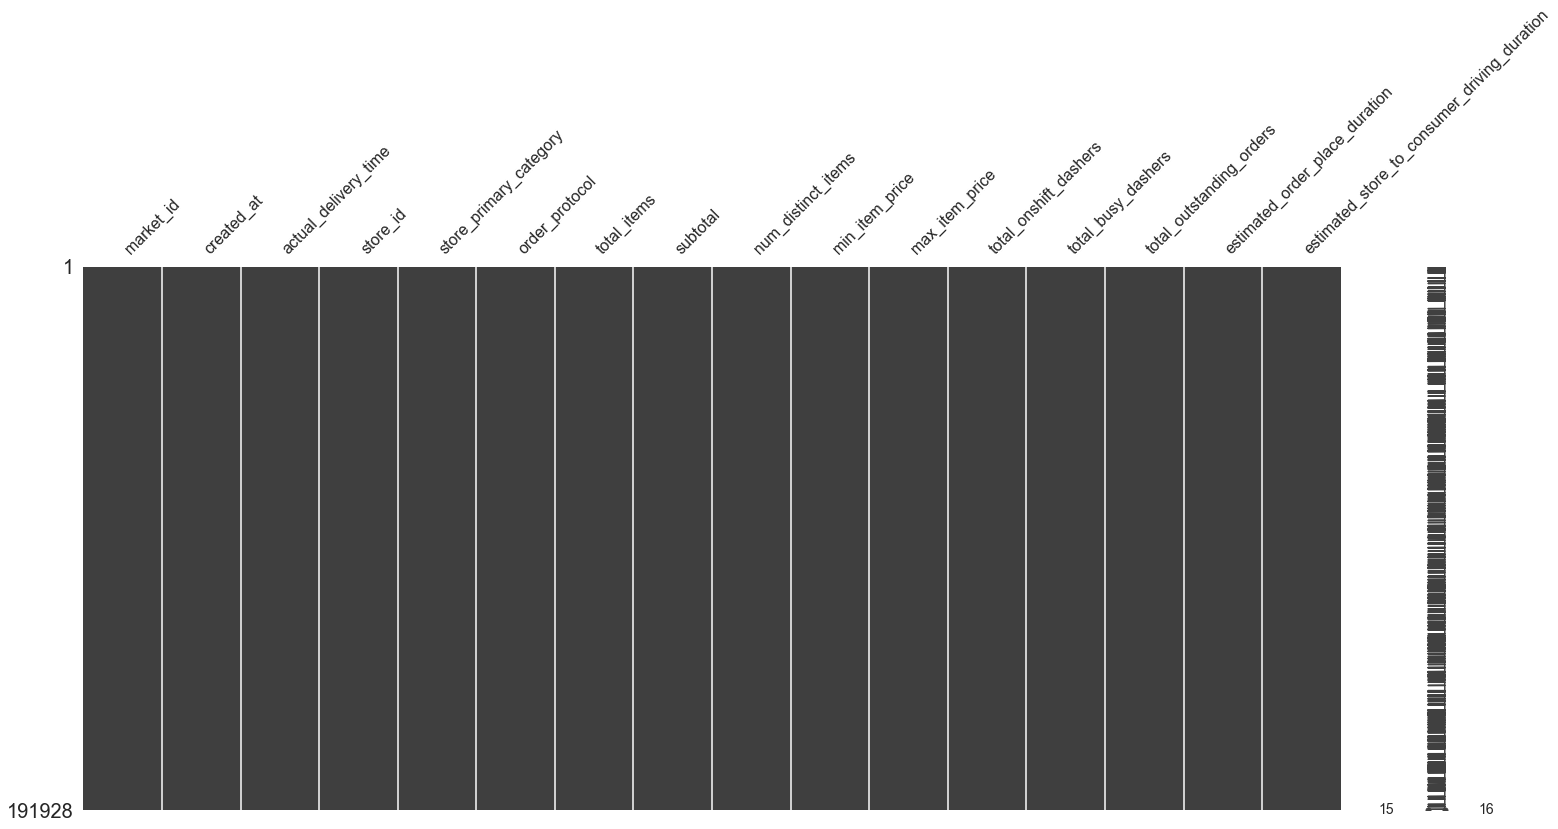

In [208]:
msno.matrix(data)

In [209]:
data.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
count,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191928.000000,191414.000000
mean,2.971760,3540.012635,2.897904,3.193505,2679.683892,2.668152,685.699570,1158.260660,44.906533,41.846416,58.208947,307.474829,545.507816
std,1.523217,2051.350641,1.501557,2.668694,1822.902612,1.628802,520.427242,557.204799,33.090369,30.814282,50.512140,89.579362,219.418717
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000
25%,2.000000,1695.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,799.000000,19.000000,17.000000,19.000000,251.000000,382.000000
50%,3.000000,3600.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,41.000000,39.000000,47.000000,251.000000,544.000000
75%,4.000000,5302.000000,4.000000,4.000000,3393.000000,3.000000,949.000000,1395.000000,62.000000,60.000000,80.000000,446.000000,702.000000
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,2715.000000,2088.000000


After cleaning our data, we now introduce new features into our dataframe.

In [210]:
import datetime
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['actual_total_delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

In [211]:
# other new features that are possibly useful
data['estimated_non_prep_duration'] = data['estimated_order_place_duration'] + data['estimated_store_to_consumer_driving_duration']
data['busy_dashers_ratio'] = data['total_busy_dashers'] / data['total_onshift_dashers']

We note that when we are dealing with ratios, there may be division by zero errors.

Get dummies for categorical features: `order_protocol`, `market_id`, `store_primary_category`

In [212]:
# create dummies for order protocol
order_protocol_dummies = pd.get_dummies(data.order_protocol, drop_first=True)
order_protocol_dummies = order_protocol_dummies.add_prefix('order_protocol_')
order_protocol_dummies.head()

,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0
0,0,0,0,0,0,0
1,1,0,0,0,0,0
8,0,1,0,0,0,0
14,0,0,0,0,0,0
15,0,0,0,0,0,0


In [213]:
# create dummies for market_id
market_id_dummies = pd.get_dummies(data.market_id, drop_first=True)
market_id_dummies = market_id_dummies.add_prefix('market_id_')
market_id_dummies.head()


,market_id_2.0,market_id_3.0,market_id_4.0,market_id_5.0,market_id_6.0
0,0,0,0,0,0
1,1,0,0,0,0
8,1,0,0,0,0
14,0,0,0,0,0
15,0,0,0,0,0


In [214]:
# create dummies for store primary category
store_primary_category_dummies = pd.get_dummies(data.store_primary_category)
store_primary_category_dummies = store_primary_category_dummies.add_prefix('category_')

In [215]:
data['store_primary_category'].mode()

0    american
Name: store_primary_category, dtype: object

In [216]:
store_primary_category_dummies = store_primary_category_dummies.drop('category_american', axis=1)

Now that we have created our dummy variables, we can drop the unnecessary columns.

In [217]:
data.columns.values

array(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price',
       'max_item_price', 'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration',
       'actual_total_delivery_duration', 'estimated_non_prep_duration',
       'busy_dashers_ratio'], dtype=object)

In [218]:
dropped_cols = ['order_protocol', 'market_id', 'store_primary_category', 'created_at', 'actual_delivery_time', 'store_id']
train_df = data.drop(columns=dropped_cols)

* `order_protocol`, `market_id`, `store_primary_category` are categorical features that have we already created dummies for
* `created_at`, `actual_delivery_time` are features that can be dropped since our goal is to predict `actual_total_delivery_duration`
* `store_id` is removed to simplify our model

In [219]:
train_df = pd.concat([train_df, order_protocol_dummies, market_id_dummies, store_primary_category_dummies], axis=1)
train_df = train_df.astype("float32")
train_df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
0,4.0,3441.0,4.0,557.0,1239.0,33.0,14.0,21.0,446.0,861.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1900.0,1.0,1400.0,1400.0,1.0,2.0,2.0,446.0,690.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,4771.0,3.0,820.0,1604.0,8.0,6.0,18.0,446.0,289.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,1.0,1525.0,1.0,1525.0,1525.0,5.0,6.0,8.0,446.0,795.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2.0,3620.0,2.0,1425.0,2195.0,5.0,5.0,7.0,446.0,205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [220]:
train_df["actual_total_delivery_duration"].describe()

count    1.919210e+05
mean     2.908290e+03
std      1.950222e+04
min      1.010000e+02
25%      2.104000e+03
50%      2.659000e+03
75%      3.380000e+03
max      8.516859e+06
Name: actual_total_delivery_duration, dtype: float64

In [221]:
train_df["estimated_non_prep_duration"].describe()

count    191414.000000
mean        853.004944
std         234.999207
min         153.000000
25%         682.000000
50%         849.000000
75%        1016.000000
max        3222.000000
Name: estimated_non_prep_duration, dtype: float64

In [222]:
train_df["busy_dashers_ratio"].describe()

count    1.884170e+05
mean              NaN
std               NaN
min              -inf
25%      8.446602e-01
50%      9.473684e-01
75%      1.000000e+00
max               inf
Name: busy_dashers_ratio, dtype: float64

`busy_dashers_ratio` contains division by zero (inf) values. We shall drop these observations.

In [223]:
np.where(np.any(~np.isfinite(train_df),axis=0) == True)

(array([ 9, 10, 11, 12], dtype=int64),)

In [224]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)

In [225]:
train_df.shape

(187866, 97)

<AxesSubplot:>

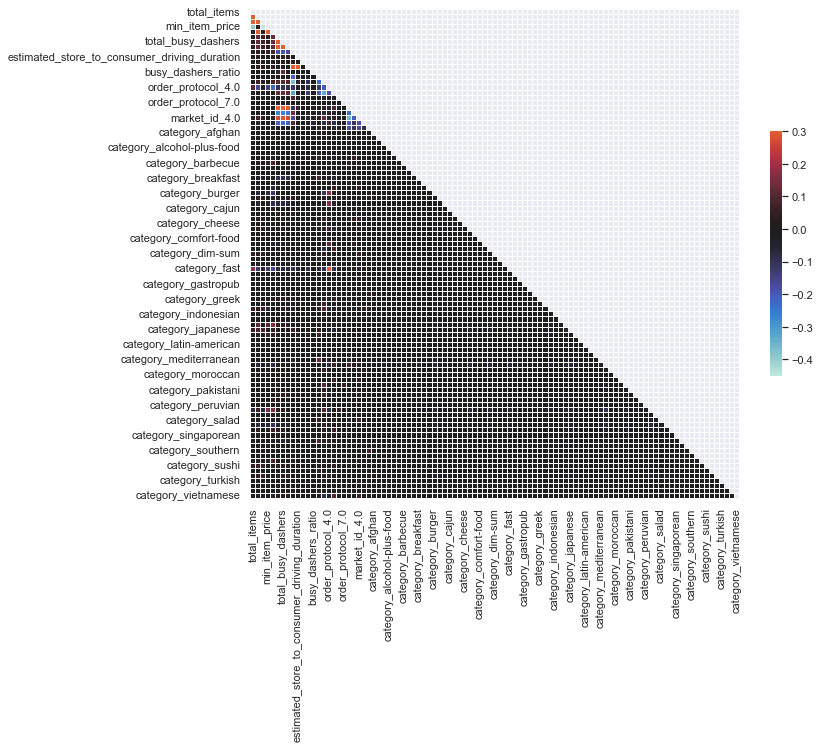

In [226]:
# it could take some time to run this cell since we are calculating correlation matrix in a dimension of (100x100)
# to have a better visualization, we will take only one triangle 
# because other triangle is only its symmetry (i.e a x b and b x a)

# Generate a mask for the upper triangle
corr = train_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("icefire", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [227]:
def get_redundant_pairs(df):
    """Get diagonal and lower triangular pairs of correlation matrix"""
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    """Sort correlations in the descending order and return n highest results"""
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [228]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_onshift_dashers                         total_busy_dashers             0.941709
                                              total_outstanding_orders       0.934587
total_busy_dashers                            total_outstanding_orders       0.931196
estimated_store_to_consumer_driving_duration  estimated_non_prep_duration    0.924666
total_items                                   num_distinct_items             0.760825
subtotal                                      num_distinct_items             0.682125
total_items                                   subtotal                       0.555243
min_item_price                                max_item_price                 0.542474
order_protocol_4.0                            category_fast                  0.509031
subtotal                                      max_item_price                 0.506313
num_distinct_items                            min_item_price                 0.450190
total_items                 

In [229]:
cols_to_drop = ['total_onshift_dashers','total_busy_dashers','estimated_non_prep_duration']
train_df = train_df.drop(columns=cols_to_drop)
train_df.shape


(187866, 94)

In [230]:
dropped_cols.extend(cols_to_drop)
dropped_cols

['order_protocol',
 'market_id',
 'store_primary_category',
 'created_at',
 'actual_delivery_time',
 'store_id',
 'total_onshift_dashers',
 'total_busy_dashers',
 'estimated_non_prep_duration']

In [231]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 50))

Top Absolute Correlations
total_items                     num_distinct_items                0.760825
subtotal                        num_distinct_items                0.682125
total_items                     subtotal                          0.555243
min_item_price                  max_item_price                    0.542474
order_protocol_4.0              category_fast                     0.509031
subtotal                        max_item_price                    0.506313
num_distinct_items              min_item_price                    0.450190
total_items                     min_item_price                    0.393214
estimated_order_place_duration  order_protocol_3.0                0.365835
market_id_2.0                   market_id_4.0                     0.362166
order_protocol_3.0              order_protocol_5.0                0.335017
estimated_order_place_duration  order_protocol_5.0                0.323711
total_outstanding_orders        market_id_2.0                     0.282559

`order_protocol` and `market_id` dummies seem to be highly correlated within their own group. We shall exclude them from our data.

In [232]:
order_protocol_dummies = ['order_protocol_'+ str(i) +'.0' for i in range(2,8)]
market_id_dummies = ['market_id_'+ str(i) +'.0' for i in range(2,6)]
dropped_dummies = order_protocol_dummies + market_id_dummies

In [233]:
train_df = train_df.drop(columns=dropped_dummies)

In [234]:
train_df.describe()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,actual_total_delivery_duration,busy_dashers_ratio,...,category_southern,category_spanish,category_steak,category_sushi,category_tapas,category_thai,category_turkish,category_vegan,category_vegetarian,category_vietnamese
count,187866.000000,187866.000000,187866.000000,187866.000000,187866.000000,187866.000000,187866.000000,187866.000000,1.878660e+05,187866.000000,...,187866.000000,187866.00000,187866.000000,187866.000000,187866.000000,187866.000000,187866.000000,187866.000000,187866.000000,187866.000000
mean,3.190998,2682.916748,2.666512,686.726440,1160.366943,59.323730,307.067963,545.495728,2.898349e+03,0.948976,...,0.000798,0.00017,0.005759,0.010619,0.000751,0.037931,0.001251,0.001464,0.004461,0.031650
std,2.670652,1822.373169,1.626163,520.531982,557.019958,50.366383,89.409569,219.294235,1.969176e+04,0.388509,...,0.028245,0.01305,0.075672,0.102502,0.027386,0.191031,0.035346,0.038232,0.066639,0.175068
min,1.000000,0.000000,1.000000,-86.000000,0.000000,-6.000000,0.000000,0.000000,1.010000e+02,-13.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1400.000000,1.000000,299.000000,800.000000,20.000000,251.000000,383.000000,2.100000e+03,0.844660,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2200.000000,2.000000,595.000000,1095.000000,49.000000,251.000000,543.000000,2.653000e+03,0.947368,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,3396.000000,3.000000,949.000000,1395.000000,81.000000,446.000000,702.000000,3.369000e+03,1.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,411.000000,27100.000000,20.000000,14700.000000,14700.000000,285.000000,2715.000000,2088.000000,8.516859e+06,31.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [235]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items               num_distinct_items                0.760825
subtotal                  num_distinct_items                0.682125
total_items               subtotal                          0.555243
min_item_price            max_item_price                    0.542474
subtotal                  max_item_price                    0.506313
num_distinct_items        min_item_price                    0.450190
total_items               min_item_price                    0.393214
                          category_fast                     0.173340
max_item_price            category_fast                     0.166732
total_outstanding_orders  estimated_order_place_duration    0.166198
max_item_price            category_italian                  0.165769
                          category_pizza                    0.163470
min_item_price            category_pizza                    0.151548
                          category_fast                     0.128232
subtotal

### Feature Engineering

In [236]:
# new features
train_df["percent_distinct_item_of_total"] = train_df["num_distinct_items"] / train_df["total_items"]
train_df["avg_price_per_item"] = train_df["subtotal"] / train_df["total_items"]
train_df.drop(columns=["num_distinct_items", "subtotal"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
min_item_price                  avg_price_per_item                0.860623
max_item_price                  avg_price_per_item                0.770317
min_item_price                  max_item_price                    0.542474
total_items                     percent_distinct_item_of_total    0.448830
                                min_item_price                    0.393214
                                avg_price_per_item                0.314680
percent_distinct_item_of_total  avg_price_per_item                0.228378
category_pizza                  avg_price_per_item                0.225858
max_item_price                  percent_distinct_item_of_total    0.180250
min_item_price                  percent_distinct_item_of_total    0.175844
category_fast                   avg_price_per_item                0.175192
total_items                     category_fast                     0.173340
max_item_price                  category_fast                     0.166732

In [237]:
train_df["price_range_of_items"] = train_df["max_item_price"] - train_df["min_item_price"]
train_df.drop(columns=["max_item_price", "min_item_price"], inplace=True)
print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 20))

Top Absolute Correlations
total_items                     percent_distinct_item_of_total    0.448830
                                price_range_of_items              0.335006
                                avg_price_per_item                0.314680
percent_distinct_item_of_total  avg_price_per_item                0.228378
category_pizza                  avg_price_per_item                0.225858
category_fast                   avg_price_per_item                0.175192
total_items                     category_fast                     0.173340
total_outstanding_orders        estimated_order_place_duration    0.166198
category_fast                   percent_distinct_item_of_total    0.155821
category_italian                avg_price_per_item                0.152862
estimated_order_place_duration  category_fast                     0.103855
category_burger                 avg_price_per_item                0.099180
category_mexican                category_pizza                    0.098840

In [238]:
train_df.shape

(187866, 83)

### Multicollinearity Check

In [239]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [240]:
def compute_vif(features):
    """Compute VIF score using variance_inflation_factor() function"""
    vif_data = pd.DataFrame()
    vif_data["feature"] = features
    vif_data["VIF"] = [VIF(train_df[features].values, i) for i in range(len(features))]
    return vif_data.sort_values(by=['VIF']).reset_index(drop=True)

In [241]:
# apply VIF computation to all columns
features = train_df.drop(columns=["actual_total_delivery_duration"]).columns.to_list()
vif_data = compute_vif(features)
vif_data

,feature,VIF
0,category_alcohol-plus-food,1.000076
1,category_chocolate,1.000128
2,category_belgian,1.000128
3,category_indonesian,1.000288
4,category_lebanese,1.000443
...,...,...
77,avg_price_per_item,5.805661
78,busy_dashers_ratio,6.452321
79,estimated_store_to_consumer_driving_duration,6.731699
80,estimated_order_place_duration,11.360577


VIF > 10 indicates unacceptably high multicollinearity. We shall remove `estimated_order_place_duration` and `percent_distinct_item_of_total`.

In [246]:
selected_features = train_df.drop(columns=['actual_total_delivery_duration', 'estimated_order_place_duration', 'percent_distinct_item_of_total']).columns.to_list()

In [247]:
vif_data = compute_vif(selected_features)
vif_data

,feature,VIF
0,category_belgian,1.000069
1,category_alcohol-plus-food,1.000069
2,category_chocolate,1.000118
3,category_indonesian,1.000237
4,category_lebanese,1.000339
...,...,...
75,total_outstanding_orders,2.518506
76,total_items,2.968098
77,avg_price_per_item,4.692260
78,busy_dashers_ratio,5.651741


### Feature Selection

In [248]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X = train_df[selected_features]
y = train_df["actual_total_delivery_duration"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

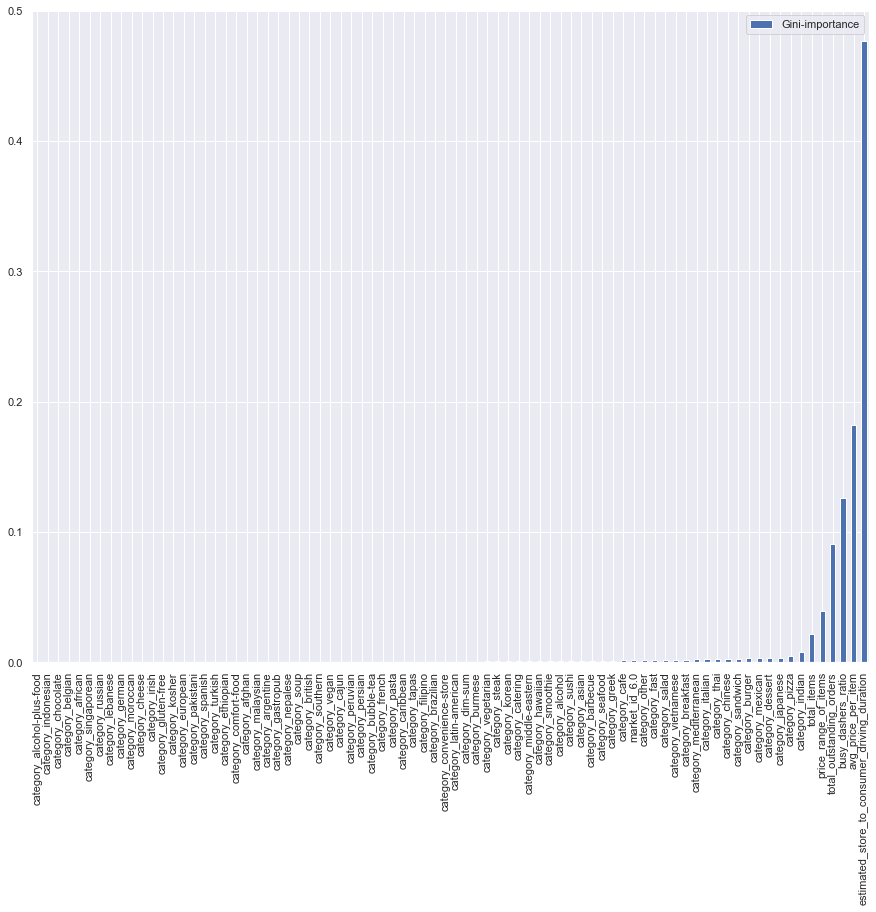

In [249]:
feature_names = [f"feature {i}" for i in range((X.shape[1]))]
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, y_train)
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

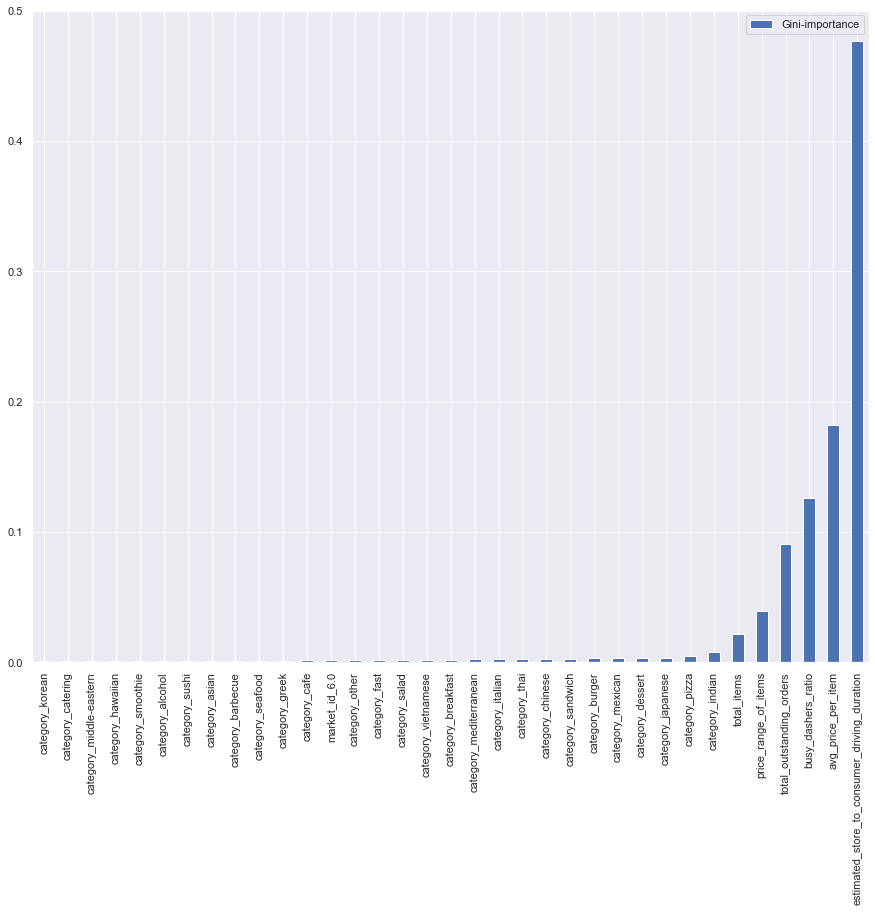

In [250]:
# check the most important ones
importances.sort_values(by='Gini-importance')[-35:].plot(kind='bar', rot=90, figsize=(15,12))
plt.show()

In [251]:
# we can obtain the column names as next
importances.sort_values(by='Gini-importance')[-35:].index.tolist()

['category_korean',
 'category_catering',
 'category_middle-eastern',
 'category_hawaiian',
 'category_smoothie',
 'category_alcohol',
 'category_sushi',
 'category_asian',
 'category_barbecue',
 'category_seafood',
 'category_greek',
 'category_cafe',
 'market_id_6.0',
 'category_other',
 'category_fast',
 'category_salad',
 'category_vietnamese',
 'category_breakfast',
 'category_mediterranean',
 'category_italian',
 'category_thai',
 'category_chinese',
 'category_sandwich',
 'category_burger',
 'category_mexican',
 'category_dessert',
 'category_japanese',
 'category_pizza',
 'category_indian',
 'total_items',
 'price_range_of_items',
 'total_outstanding_orders',
 'busy_dashers_ratio',
 'avg_price_per_item',
 'estimated_store_to_consumer_driving_duration']

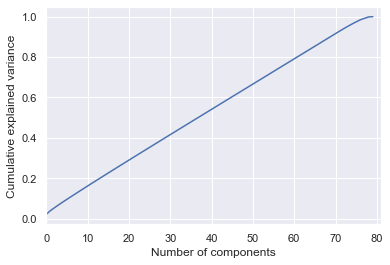

In [252]:
# apply PCA to see feature contributions
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,81,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

### Scale the Data

In [253]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale(scaler, X, y):
    """Apply the selected scaler to features and target variables"""
    X_scaler = scaler
    X_scaler.fit(X=X, y=y)
    X_scaled = X_scaler.transform(X)
    y_scaler = scaler
    y_scaler.fit(y.values.reshape(-1, 1))
    y_scaled = y_scaler.transform(y.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, X_scaler, y_scaler

In [254]:
# example to show how to use it
X_scaled, y_scaled, X_scaler, y_scaler = scale(MinMaxScaler(), X, y)

In [255]:
# train-test split after scaling
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
        X_scaled, y_scaled, test_size=0.2, random_state=42)

### Inverse Transform for Metric Comparison

In [256]:
from sklearn.metrics import mean_squared_error

def rmse_with_inv_transform(scaler, y_test, y_pred_scaled, model_name):
    """Convert the scaled error to actual error"""
    y_predict = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    # return RMSE with squared False     
    rmse_error = mean_squared_error(y_test, y_predict[:,0], squared=False)
    print("Error = "'{}'.format(rmse_error)+" in " + model_name)
    
    return rmse_error, y_predict

### Classical Machine Learning

In [257]:
# create a generic function which can work with multiple machine learning models
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """Apply selected regression model to data and measure error"""
    model.fit(X_train,y_train)
    y_predict=model.predict(X_train)
    train_error = mean_squared_error(y_train, y_predict, squared=False)
    y_predict=model.predict(X_test)
    test_error = mean_squared_error(y_test, y_predict, squared=False)
    if verbose:
        print("Train error = "'{}'.format(train_error)+" in " + model_name)
        print("Test error = "'{}'.format(test_error)+" in " + model_name)
    trained_model = model
    
    return trained_model, y_predict, train_error, test_error

In [258]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import svm
from sklearn import neighbors
from sklearn import linear_model

pred_dict = {
    "regression_model": [],
    "feature_set": [],
    "scaler_name": [],
    "RMSE": [],
}


regression_models = {
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}

feature_sets = {
    "full dataset": X.columns.to_list(),
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
    "selected_features_20": importances.sort_values(by='Gini-importance')[-20:].index.tolist(),
    "selected_features_10": importances.sort_values(by='Gini-importance')[-10:].index.tolist(), 

    
}

scalers = {
    "Standard scaler": StandardScaler(),
    "MinMax scaler": MinMaxScaler(),
    "NotScale": None,
}

# examine the error for each combination
for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():   
            if scaler_name == "NotScale":
                X = train_df[feature_set]
                y = train_df["actual_total_delivery_duration"]
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
                make_regression(X_train, y_train, X_test, y_test, regression_models[model_name], model_name, verbose=True)
            
            else:
                
                X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X[feature_set], y)
                X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
                    X_scaled, y_scaled, test_size=0.2, random_state=42)
                _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
                rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)

            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are full dataset

Error = 1131.2186279296875 in Ridge
Error = 1105.3129341845706 in DecisionTree
Error = 8284.24101430238 in RandomForest
Error = 1118.9837646484375 in XGBoost
Error = 4425.089138763326 in LGBM
Error = 1668.219482421875 in MLP
-----scaled with MinMax scaler-------- included columns are full dataset

Error = 1131.7451171875 in Ridge
Error = 1105.3129338198753 in DecisionTree
Error = 3943.2788362739466 in RandomForest
Error = 1760.397705078125 in XGBoost
Error = 4807.63536805767 in LGBM
Error = 6902.63330078125 in MLP
-----scaled with NotScale-------- included columns are full dataset

Train error = 22003.140625 in Ridge
Test error = 1131.1962890625 in Ridge


c:\Users\HangWei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=4.67927e-11): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1370.632284404613 in DecisionTree
Test error = 1105.3129340497653 in DecisionTree
Train error = 10203.901401121264 in RandomForest
Test error = 3607.8258003108554 in RandomForest
Train error = 1109.912841796875 in XGBoost
Test error = 1078.6717529296875 in XGBoost
Train error = 16733.98057728125 in LGBM
Test error = 5024.938055822781 in LGBM
Train error = 22006.912109375 in MLP
Test error = 1120.9007568359375 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_40

Error = 1131.9931640625 in Ridge
Error = 1105.3129341845706 in DecisionTree
Error = 7333.872821334104 in RandomForest
Error = 1234.9840087890625 in XGBoost
Error = 4425.089138763326 in LGBM
Error = 1160.211669921875 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_40

Error = 1132.52978515625 in Ridge
Error = 1105.3129338198753 in DecisionTree
Error = 3894.055203019784 in RandomForest
Error = 1760.397705078125 in XGBoost
Error = 4807.63585899

c:\Users\HangWei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.77229e-09): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1370.632284404613 in DecisionTree
Test error = 1105.3129340497653 in DecisionTree
Train error = 10196.771508495376 in RandomForest
Test error = 5479.516572429711 in RandomForest
Train error = 1070.2974853515625 in XGBoost
Test error = 1076.9072265625 in XGBoost
Train error = 16733.980700942928 in LGBM
Test error = 5024.9380245008415 in LGBM
Train error = 22007.3984375 in MLP
Test error = 1166.9666748046875 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_20

Error = 1132.6248779296875 in Ridge
Error = 1105.3116052499477 in DecisionTree
Error = 8036.298083096118 in RandomForest
Error = 1288.5595703125 in XGBoost
Error = 5495.075021806968 in LGBM
Error = 1232.5687255859375 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_20

Error = 1133.1346435546875 in Ridge
Error = 1105.3116048851027 in DecisionTree
Error = 3027.4394689885316 in RandomForest
Error = 3252.178955078125 in XGBoost
Error = 5260.7714223

c:\Users\HangWei\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.82382e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Train error = 1370.6319628420054 in DecisionTree
Test error = 1120.0921432320686 in DecisionTree
Train error = 10618.47102755227 in RandomForest
Test error = 3527.4232492817214 in RandomForest
Train error = 1041.897216796875 in XGBoost
Test error = 1237.453369140625 in XGBoost
Train error = 16512.754118855493 in LGBM
Test error = 5260.771572208432 in LGBM
Train error = 22007.2265625 in MLP
Test error = 1126.427978515625 in MLP
-----scaled with Standard scaler-------- included columns are selected_features_10

Error = 1103.3631591796875 in Ridge
Error = 1100.210176906872 in DecisionTree
Error = 1097.720988167468 in RandomForest
Error = 1332.6636962890625 in XGBoost
Error = 5267.335310566859 in LGBM
Error = 1222.025634765625 in MLP
-----scaled with MinMax scaler-------- included columns are selected_features_10

Error = 1103.854736328125 in Ridge
Error = 1100.210176544657 in DecisionTree
Error = 1099.5776955455078 in RandomForest
Error = 2815.330078125 in XGBoost
Error = 2963.43334386630

In [259]:
pred_df = pd.DataFrame(pred_dict)

In [260]:
pred_df

,regression_model,feature_set,scaler_name,RMSE
0,Ridge,full dataset,Standard scaler,1131.218628
1,DecisionTree,full dataset,Standard scaler,1105.312934
2,RandomForest,full dataset,Standard scaler,8284.241014
3,XGBoost,full dataset,Standard scaler,1118.983765
4,LGBM,full dataset,Standard scaler,4425.089139
...,...,...,...,...
67,DecisionTree,selected_features_10,NotScale,2530.204590
68,RandomForest,selected_features_10,NotScale,2530.204590
69,XGBoost,selected_features_10,NotScale,2530.204590
70,LGBM,selected_features_10,NotScale,2530.204590


<AxesSubplot:>

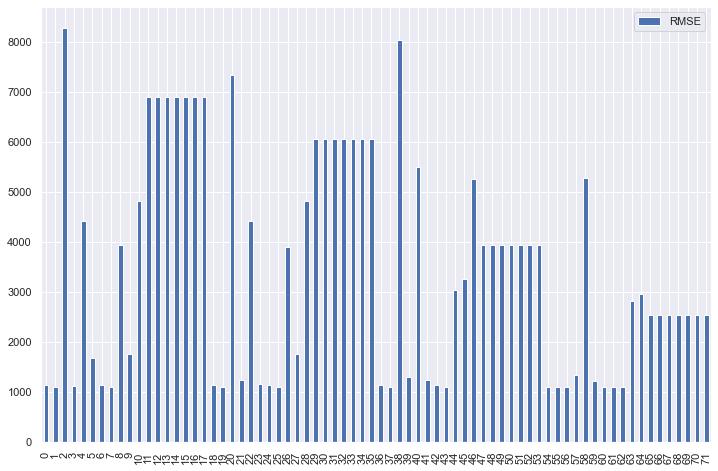

In [261]:
pred_df.plot(kind='bar', figsize=(12,8))

In [262]:
# change the problem a bit
train_df["prep_time"] = train_df["actual_total_delivery_duration"] - train_df["estimated_store_to_consumer_driving_duration"] - train_df["estimated_order_place_duration"]

# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

-----scaled with Standard scaler-------- included columns are selected_features_40



KeyError: "['estimated_order_place_duration'] not found in axis"

In [ ]:
# not scaling affects the performance, so continue to scale but it doesn't matter much which scaler we used
scalers = {
    "Standard scaler": StandardScaler(),
}

feature_sets = {
    "selected_features_40": importances.sort_values(by='Gini-importance')[-40:].index.tolist(),
}

# continue with best performing model
regression_models = {
    "LGBM": LGBMRegressor(),
}

for feature_set_name in feature_sets.keys():
    feature_set = feature_sets[feature_set_name]
    for scaler_name in scalers.keys():
        print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
        print("")
        for model_name in regression_models.keys():  
            #drop estimated_store_to_consumer_driving_duration and estimated_order_place_duration
            X = train_df[feature_set].drop(columns=["estimated_store_to_consumer_driving_duration", 
                                           "estimated_order_place_duration"])
            y = train_df["prep_time"]
            
            # to get indices
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            train_indices = X_train.index
            test_indices  = X_test.index
            
            # scale
            X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
            
            # apply indexing
            X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
            _, y_predict_scaled, _, _ = make_regression(X_train_scaled, y_train_scaled[:,0], X_test_scaled, y_test_scaled[:,0], regression_models[model_name], model_name, verbose=False)
            rmse_error, y_predict = rmse_with_inv_transform(y_scaler, y_test, y_predict_scaled, model_name)
            pred_dict["regression_model"].append(model_name)
            pred_dict["feature_set"].append(feature_set_name)
            pred_dict["scaler_name"].append(scaler_name)
            pred_dict["RMSE"].append(rmse_error)

In [ ]:
# choose best perform model and extract the predictions for preparation duration
pred_values_dict = {
    "actual_total_delivery_duration": train_df["actual_total_delivery_duration"][test_indices].values.tolist(), 
    "prep_duration_prediction":y_predict[:,0].tolist(),
    "estimated_store_to_consumer_driving_duration": train_df["estimated_store_to_consumer_driving_duration"][test_indices].values.tolist(),
    "estimated_order_place_duration": train_df["estimated_order_place_duration"][test_indices].values.tolist(),             
}

In [ ]:
# convert it to dataframe from dict
values_df = pd.DataFrame.from_dict(pred_values_dict)
values_df

In [ ]:
# sum predictions up with non preparation activities such as order placing and driving.
values_df["sum_total_delivery_duration"] = values_df["prep_duration_prediction"] + values_df["estimated_store_to_consumer_driving_duration"] + values_df["estimated_order_place_duration"]
values_df

In [ ]:
# check new error rate
mean_squared_error(values_df["actual_total_delivery_duration"], values_df["sum_total_delivery_duration"], squared=False)

In [ ]:
# What if we use another regression to obtain the actual total delivery duration?
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
regression_models = {
    "LinearReg" : linear_model.LinearRegression(),
    "Ridge" : linear_model.Ridge(),
    "DecisionTree" : tree.DecisionTreeRegressor(max_depth=6),
    "RandomForest" : RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LGBM": LGBMRegressor(),
    "MLP":  MLPRegressor(),
}
for model_name in regression_models.keys():
    _, y_predict, _, _= make_regression(
        X_train, y_train, X_test, y_test,regression_models[model_name], model_name, verbose=False)
    print("RMSE of:",model_name, mean_squared_error(y_test,y_predict, squared=False))

### Deep Learning

In [ ]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

# Neural network
def create_model(feature_set_size):
    
    # define the model
    model = Sequential()
    model.add(Dense(16, input_dim=feature_set_size, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    # compile the model
    model.compile(optimizer='sgd', loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    return model

In [ ]:
print(f"-----scaled with {scaler_name}-------- included columns are {feature_set_name}")
print("")
model_name = "ANN"   
scaler_name = "Standard scaler"
X = values_df[["prep_duration_prediction", "estimated_store_to_consumer_driving_duration", "estimated_order_place_duration"]]
y = values_df["actual_total_delivery_duration"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled, y_scaled, X_scaler, y_scaler = scale(scalers[scaler_name], X, y)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
print("feature_set_size:",X_train_scaled.shape[1])
model = create_model(feature_set_size=X_train_scaled.shape[1])
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=64, verbose=1)
y_pred = model.predict(X_test_scaled)
rmse_error = rmse_with_inv_transform(y_scaler, y_test, y_pred, model_name)
pred_dict["regression_model"].append(model_name)
pred_dict["feature_set"].append(feature_set_name)
pred_dict["scaler_name"].append(scaler_name)
pred_dict["RMSE"].append(rmse_error)

In [ ]:
plt.plot(history.history['loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.show()